In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pickle
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score , classification_report ,confusion_matrix ,precision_recall_curve ,auc


In [3]:
df = pd.read_csv(r"D:\AnacondaProjects\EmployeePerformance\data\processed\train_encoded.csv")

print(df.shape)
df.head(2)

(1200, 11)


,EmpLastSalaryHikePercent,YearsSinceLastPromotion,EmpEnvironmentSatisfaction,EmpDepartment,DistanceFromHome,OverTime,EmpHourlyRate,EmpWorkLifeBalance,TrainingTimesLastYear,NumCompaniesWorked,PerformanceRating
0,12,0,4,5,10,0,55,2,2,1,1
1,12,1,4,5,14,0,42,3,2,2,1


### Define predictor(X) and target(y) variables

In [4]:
X_test= df.loc[:,df.columns != 'PerformanceRating']
y_test= df['PerformanceRating']

## Importing Trained XGBModel(SelectKBest) and predicting the Performance of Employee

In [8]:
filename = 'D:\AnacondaProjects\EmployeePerformance\src\models\model_XGB_SKB.sav'
XGB_Model = pickle.load(open(filename, 'rb'))
result = XGB_Model.score(X_test, y_test)
y_predict = XGB_Model.predict(X_test)
print("Accuracy of XGB_Model with SelectKBest featues : {} {}".format(accuracy_score(y_test,y_predict).round(4)*100 , "%"))
print("-"*60)
print(classification_report(y_test,y_predict))
print("-"*60)
print("COnfusion Matrix \n" ,pd.crosstab(y_test,y_predict))

Accuracy of XGB_Model with SelectKBest featues : 99.17 %
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       194
           1       1.00      0.99      0.99       874
           2       0.99      0.99      0.99       132

    accuracy                           0.99      1200
   macro avg       0.99      0.99      0.99      1200
weighted avg       0.99      0.99      0.99      1200

------------------------------------------------------------
COnfusion Matrix 
 col_0                0    1    2
PerformanceRating               
0                  191    3    0
1                    5  868    1
2                    0    1  131


## Importing Trained RandomForest and predicting the Performance of Employee

In [9]:
filename = 'D:\AnacondaProjects\EmployeePerformance\src\models\model_rf.sav'
model_rf = pickle.load(open(filename, 'rb'))
result = model_rf.score(X_test, y_test)
y_predict2 = model_rf.predict(X_test)

print("Acuuracy of Random Forest with SelectKBest featues : {} {}".format(accuracy_score(y_test,y_predict2).round(4)*100 , "%"))
print("-"*60)
print(classification_report(y_test,y_predict2))
print("-"*60)
print("COnfusion Matrix \n" ,pd.crosstab(y_test,y_predict2))


Acuuracy of Random Forest with SelectKBest featues : 98.83 %
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       194
           1       1.00      0.99      0.99       874
           2       0.98      0.99      0.99       132

    accuracy                           0.99      1200
   macro avg       0.98      0.99      0.98      1200
weighted avg       0.99      0.99      0.99      1200

------------------------------------------------------------
COnfusion Matrix 
 col_0                0    1    2
PerformanceRating               
0                  192    2    0
1                    9  863    2
2                    0    1  131


## Evaluate XGB model performance

In [10]:
#Define Result lists
y_test = pd.DataFrame(y_test)
y_predict = pd.DataFrame(y_predict ,columns =['y_Predict_Status'])
Proba =XGB_Model.predict_proba(X_test)
Proba.shape

(1200, 3)

In [11]:
Proba =pd.DataFrame(Proba)
Proba.head()

,0,1,2
0,0.000007,0.999981,0.000013
1,0.000009,0.999987,0.000004
2,0.000002,0.000284,0.999714
3,0.028635,0.971197,0.000168
4,0.020254,0.979740,0.000006


In [12]:
ConsolidatedData1 = np.concatenate([np.array(y_test),np.array(y_predict),np.array(Proba)],axis=1)
ConsolidatedData1 = pd.DataFrame(ConsolidatedData1,columns=['y_test','y_predict','Proba_0','Proba_1','Proba_2'])
ConsolidatedData1 = pd.DataFrame(ConsolidatedData1)
ConsolidatedData1.head()

,y_test,y_predict,Proba_0,Proba_1,Proba_2
0,1.0,1.0,0.000007,0.999981,0.000013
1,1.0,1.0,0.000009,0.999987,0.000004
2,2.0,2.0,0.000002,0.000284,0.999714
3,1.0,1.0,0.028635,0.971197,0.000168
4,1.0,1.0,0.020254,0.979740,0.000006


In [13]:
print(pd.crosstab(ConsolidatedData1.y_test,ConsolidatedData1.y_predict))
print(classification_report(ConsolidatedData1.y_test,ConsolidatedData1.y_predict))
ConsolidatedData1.count()

y_predict  0.0  1.0  2.0
y_test                  
0.0        191    3    0
1.0          5  868    1
2.0          0    1  131
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98       194
         1.0       1.00      0.99      0.99       874
         2.0       0.99      0.99      0.99       132

    accuracy                           0.99      1200
   macro avg       0.99      0.99      0.99      1200
weighted avg       0.99      0.99      0.99      1200



y_test       1200
y_predict    1200
Proba_0      1200
Proba_1      1200
Proba_2      1200
dtype: int64

In [14]:
#Define Result lists

Accuracy =[]
Recall =[]
Precision=[]
Threshold =[]

#Set new col to zero
ConsolidatedData1['y_Pred_new'] =0

#Loop to evaluate the threshold
for i in range(5,95,1):
    ConsolidatedData1.loc[ConsolidatedData1.Proba_1 > i/100 , 'y_Pred_new']=1
    z = pd.crosstab(ConsolidatedData1.y_test , ConsolidatedData1.y_Pred_new)
    #print(z)
    Threshold.append(i/100)
    Accuracy.append(((z[0][0] + z[1][1])/(z[0][0]+z[0][1]+z[1][0]+z[1][1])) *100)
    Precision.append((z[1][1]/(z[1][0]+z[1][1]))*100)
    Recall.append((z[1][1]/(z[0][1]+z[1][1]))*100)
    ConsolidatedData1['y_Pred_new']=0

#Convert the lists into a single data frame

Result = pd.DataFrame({'Threshold' : Threshold ,
                      'Accuracy' : Accuracy,
                      'Recall':Recall,
                      'Precision':Precision})
Result.loc[Result.Accuracy > 76]

,Threshold,Accuracy,Recall,Precision
0,0.05,98.970037,99.542334,99.201824
1,0.06,98.970037,99.542334,99.201824
2,0.07,98.970037,99.542334,99.201824
3,0.08,98.970037,99.542334,99.201824
4,0.09,98.970037,99.542334,99.201824
...,...,...,...,...
85,0.90,98.782772,98.741419,99.768786
86,0.91,98.782772,98.741419,99.768786
87,0.92,98.782772,98.741419,99.768786
88,0.93,98.782772,98.741419,99.768786


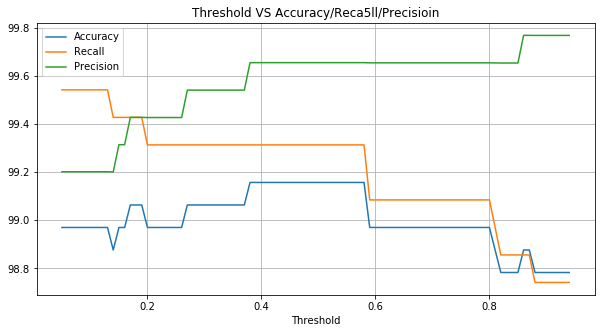

In [15]:
Result.plot(x='Threshold',
           y=['Accuracy','Recall','Precision'],
           kind='line',
           grid=True,
           title='Threshold VS Accuracy/Reca5ll/Precisioin',
           legend=True,
           figsize =(10,5))

#Choose threshold as 0.5 as its giving better accuracy: